In [197]:
import pandas as pd
import numpy as np
import scipy.io
import math
from collections import Counter
import copy
import warnings
import tensorflow 
from tensorflow.keras.layers import Dense, Input,Conv1D, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
def rms(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    mean = (sum / (float)(n))
    root = math.sqrt(mean)
    return root
def mav(arr):
    n = len(arr)
    mav = sum((abs(np.array(arr))))/(float)(n)
    return mav
def var(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    result = (sum / (float)(n))
    return result
def wl(arr):
    n = len(arr)
    sum = 0
    for i in range(1, n):
        sum += abs(arr[i] - arr[i - 1])
    return sum
def iav(arr):
    return sum(abs(np.array(arr)))
def mean(arr):
    return np.sum(arr)/len(arr)
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):

            pretty(value, indent + 2)
            print('-----------------------')
        else:
            print('\t' * (indent + 2) + str(value))
            print(" ")
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)
def extractSubject(name):
    ex1Path = 'DB1/' + name + '/' + name + '_A1_E1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    emg = ex1['emg']
    EMGdf = pd.DataFrame.from_dict(emg)
    stimulus = ex1['restimulus']

    ex2Path = 'DB1/' + name + '/' + name + '_A1_E2.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    emg2 = ex2['emg']
    EMGdf2 = pd.DataFrame.from_dict(emg2)
    stimulus2 = ex2['restimulus']

    ex3Path = 'DB1/' + name + '/' + name + '_A1_E3.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    emg3 = ex3['emg']
    EMGdf3 = pd.DataFrame.from_dict(emg3)
    stimulus3 = ex3['restimulus']

    Movements = {}
    for m in range(1, 51):
        if (m < 11):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf
        elif (m < 28):
            movementIndices = np.where(stimulus2 == (m - 10))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf2
        else:
            movementIndices = np.where(stimulus3 == (m - 27))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf3

        Electrodes = {}
        for e in range(1, 11):
            temp = {}
            for r in range(1, 7):
                startIndex = repetitions[r - 1][0]
                LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
                df = EMG.iloc[startIndex:LastIndex, e - 1]
                df.reset_index(drop=True, inplace=True)
                narray = df.to_numpy(dtype=None, copy=False)
                temp["R{0}".format(r)] = narray
            Electrodes["Electrode{0}".format(e)] = temp
        Movements["Movement{0}".format(m)] = Electrodes
    return Movements
def extractSubjectAngles(name):
    ex1Path = 'Kinematics/' + name + '/' + name + '_E1_A1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    angles1 = ex1['angles']
    anglesDF1 = pd.DataFrame.from_dict(angles1)
    stimulus = ex1['restimulus']

    ex2Path = 'Kinematics/' + name + '/' + name + '_E2_A1.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    angles2 = ex2['angles']
    anglesDF2 = pd.DataFrame.from_dict(angles2)
    stimulus2 = ex2['restimulus']

    ex3Path = 'Kinematics/' + name + '/' + name + '_E3_A1.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    angles3 = ex3['angles']
    anglesDF3 = pd.DataFrame.from_dict(angles3)
    stimulus3 = ex3['restimulus']

    Movements = {}
    for m in range(1, 51):
        if (m < 11):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF1
        elif (m < 28):
            movementIndices = np.where(stimulus2 == (m - 10))[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF2
        else:
            movementIndices = np.where(stimulus3 == (m - 27))[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF3

        Angles = {}
        for a in range(1,23):
            if a == 6:
               Angles["Angle6"] = ""
               continue

            temp={}
            for r in range(1, 7):
                startIndex = repetitions[r - 1][0]
                LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
                df = angle.iloc[startIndex:LastIndex, a-1]
                df.reset_index(drop=True, inplace=True)
                narray = df.to_numpy(dtype=None, copy=False)
                temp["R{0}".format(r)] = narray
            Angles["Angle{0}".format(a)] = temp
        Movements["Movement{0}".format(m)] = Angles

    return Movements


In [436]:
final_df = pd.DataFrame(columns={
    # 'RMS1','RMS2','RMS3','RMS3','RMS4','RMS5','RMS6','RMS7','RMS8','RMS9','RMS10'
                                'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                                 'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                                 'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                                 'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                                 'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                                 'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                                 'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                                 'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                                 'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                                 'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                                 'Train'})
final_df_angle = pd.DataFrame(columns={})
df_angle = pd.DataFrame(columns={})
i=0
for s in [1,3,6,13,23]:
    subject = 'S' + str(s)
    df_angles = pd.DataFrame.from_dict(extractSubjectAngles(subject))
    for m in range(45,51):
        M = df_angles['Movement'+str(m)]
        start = copy.deepcopy(i)
        for a in range (1,23):
            if a==6:
                continue

            Angles = M['Angle' +str(a)]
            for r in range(1,7):
                rep = "R" + str(r)
                for x in range(0, len(Angles[rep]), 20):
                    df_angle.at[i, a-1] = mean(Angles[rep][x:x + 50])
                    i += 1
            if a != 22:
                i = copy.deepcopy(start)
    final_df_angle = final_df_angle.append(df_angle, ignore_index=True)            

Kinematics/S1/S1_E1_A1.mat
Kinematics/S3/S3_E1_A1.mat
Kinematics/S6/S6_E1_A1.mat
Kinematics/S13/S13_E1_A1.mat
Kinematics/S23/S23_E1_A1.mat


In [437]:
for s in [1,3,6,13,23]:
    subject = 'S' + str(s)
    dff = pd.DataFrame.from_dict(extractSubject(subject))
    df = pd.DataFrame(columns={'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                           'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                           'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                           'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                           'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                           'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                           'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                           'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                           'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                           'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                           'Train'})
    for e in range(1, 11):
        electrode = 'Electrode' + str(e)
        i=0
        for m in range(45,51):
            M = dff['Movement'+str(m)][electrode]
            for r in range(1, 7):
                rep = "R" + str(r)
                if (r in [1, 3, 4, 6]):
                    train = 1
                else:
                    train = 0
                for x in range(0, len(M[rep]), 48):
                    df.at[i, 'RMS' + str(e)] = rms(M[rep][x:x + 50])
                    df.at[i, 'MAV' + str(e)] = mav(M[rep][x:x + 50])
                    df.at[i, 'VAR' + str(e)] = var(M[rep][x:x + 50])
                    df.at[i, 'WL' + str(e)] = wl(M[rep][x:x + 50])
                    df.at[i, 'IAV' + str(e)] = iav(M[rep][x:x + 50])
                    df.at[i, 'Train'] = train
                    i += 1
    final_df = final_df.append(df, ignore_index=True)

DB1/S1/S1_A1_E1.mat
DB1/S3/S3_A1_E1.mat
DB1/S6/S6_A1_E1.mat
DB1/S13/S13_A1_E1.mat
DB1/S23/S23_A1_E1.mat


In [438]:
# final_df['CMC1_f'] = df_angle[0]
# final_df['CMC1_a'] =  df_angle[1]
final_df['MCP1'] =  df_angle[2]
final_df['IP1'] =  df_angle[3]
final_df['MCP2_f'] =  df_angle[4]
final_df['PIP2'] =  df_angle[6]
final_df['MCP3_f'] =  df_angle[7]
final_df['PIP3'] =  df_angle[8]
final_df['MCP4_f'] =  df_angle[9]
# final_df['MCP4_a'] =  df_angle[10]
final_df['PIP4'] =  df_angle[11]
# final_df['CMC5'] =  df_angle[12]
final_df['MCP5_f'] =  df_angle[13]
# final_df['MCP5_a'] =  df_angle[14]
final_df['PIP5'] =  df_angle[15]
# final_df['DIP2'] =  df_angle[16]
# final_df['DIP3'] =  df_angle[17]
# final_df['DIP4'] =  df_angle[18]
# final_df['DIP5'] =  df_angle[19]
# final_df['WRIST_F'] =  df_angle[20]
# final_df['WRIST_A'] =  df_angle[21]

features = {
        # 'RMS1','RMS2','RMS3','RMS3','RMS4','RMS5','RMS6','RMS7','RMS8','RMS9','RMS10',
            'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
            'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
            'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
            'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
            'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
            'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
            'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
            'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
            'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
            'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10' 
            }

angles = {'MCP1','IP1','MCP2_f','PIP2','MCP3_f', 'PIP3','MCP4_f', 'PIP4', 'MCP5_f', 'PIP5'
        # 'CMC1_f','CMC1_a','MCP1','IP1','MCP2_f',
        # 'PIP2','MCP3_f','MCP4_f','MCP4_a',
        # 'PIP4','CMC5','MCP5_a','PIP5',
        # 'DIP2','DIP4','DIP5', 'DIP3', 'PIP3'
        }

print(final_df)

          RMS7      MAV8     WL4     RMS10      MAV6      VAR4      VAR5  \
0     0.328661  1.015672  0.0514  0.002936  0.004814  0.000382  0.000828   
1     0.261609  2.132426   0.176  0.034077  0.007508   0.00261  0.002031   
2     0.152492  1.782958  0.2244  0.013694  0.004916  0.003115  0.000382   
3     0.200848   1.79585  0.3003  0.020289  0.006242   0.00971  0.000895   
4     0.107036  1.464992  0.1905  0.002833  0.003928  0.003229  0.000086   
...        ...       ...     ...       ...       ...       ...       ...   
1647  0.084302  0.492146  0.2904  0.138936  0.008282  0.004413  0.000082   
1648  0.558796   0.82412  0.2442  0.360919  0.070076    0.0011  0.000719   
1649   0.36972  0.660156  0.0807   0.26272  0.021908  0.000071   0.00004   
1650  1.154071  1.945852  0.1516  1.587032  0.119674   0.00088  0.003034   
1651  0.276064  0.984919     0.0   0.60758  0.011808  0.000006  0.000006   

          VAR1      MAV1     IAV2  ...      MCP1        IP1     MCP2_f  \
0     0.09954

In [439]:
X_train = final_df[final_df['Train'] == 1].loc[:, features]
scalar =  StandardScaler()
scalar = scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = final_df[final_df['Train'] == 0].loc[:, features]
X_test = scalar.transform(X_test)

y_train = final_df[final_df['Train'] == 1].loc[:, angles]
y_test = final_df[final_df['Train'] == 0].loc[:, angles]
y_test.to_csv('angles_y_test.csv')



In [448]:
input = Input(shape =(50,))
x = Dense(5, activation='tanh')(input)
x = Dense(5, activation='tanh')(x)
x = Dropout(0.1)(x)
ouput = Dense(10, activation='linear')(x)
model = Model(input, ouput)
model.compile(optimizer=Adam(learning_rate=0.002), loss="mean_squared_error", metrics=['mse'])
model.fit(X_train, y_train, epochs=1000)
print(model.evaluate(X_test, y_test))

Epoch 1/1000
35/35 [==============================] - 0s 2ms/step - loss: 1507.2587 - mse: 1507.2587
Epoch 2/1000
35/35 [==============================] - 0s 3ms/step - loss: 1494.9912 - mse: 1494.9912
Epoch 3/1000
35/35 [==============================] - 0s 858us/step - loss: 1479.2169 - mse: 1479.2169
Epoch 4/1000
35/35 [==============================] - 0s 474us/step - loss: 1457.6591 - mse: 1457.6591
Epoch 5/1000
35/35 [==============================] - 0s 613us/step - loss: 1432.4081 - mse: 1432.4081
Epoch 6/1000
35/35 [==============================] - 0s 513us/step - loss: 1401.9269 - mse: 1401.9269
Epoch 7/1000
35/35 [==============================] - 0s 473us/step - loss: 1370.2181 - mse: 1370.2181
Epoch 8/1000
35/35 [==============================] - 0s 859us/step - loss: 1342.5134 - mse: 1342.5134
Epoch 9/1000
35/35 [==============================] - 0s 977us/step - loss: 1318.3698 - mse: 1318.3698
Epoch 10/1000
35/35 [==============================] - 0s 695us/step - loss: 

In [441]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)
input = Input(shape =(50,1))
x = Conv1D(32,31, activation='relu', padding='same', input_shape = (X_train.shape[1],1))(input)
x = Conv1D(64,31, activation='relu' ,padding='same' )(x)
x = BatchNormalization()(x)
x = Conv1D(64,31, activation='relu', padding='same')(x)
x = Conv1D(32,31, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(10,31, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
ouput = Dense(10, activation='linear')(x)
model = Model(input, ouput)
model.compile(optimizer=Adam(learning_rate=0.003), loss="mean_squared_error", metrics=['mse'])
model.fit(X_train, y_train, epochs=1000)
print(model.evaluate(X_test, y_test))





X Train shape:  (1089, 50, 1)
X Test shape:  (563, 50, 1)
Epoch 1/1000
35/35 [==============================] - 1s 17ms/step - loss: 1371.8015 - mse: 1371.8015
Epoch 2/1000
35/35 [==============================] - 1s 17ms/step - loss: 1162.2086 - mse: 1162.2086
Epoch 3/1000
35/35 [==============================] - 1s 17ms/step - loss: 953.9870 - mse: 953.9870
Epoch 4/1000
35/35 [==============================] - 1s 17ms/step - loss: 873.5212 - mse: 873.5212
Epoch 5/1000
35/35 [==============================] - 1s 17ms/step - loss: 805.8072 - mse: 805.8072
Epoch 6/1000
35/35 [==============================] - 1s 21ms/step - loss: 757.1574 - mse: 757.1574
Epoch 7/1000
35/35 [==============================] - 1s 18ms/step - loss: 772.4919 - mse: 772.4919
Epoch 8/1000
35/35 [==============================] - 1s 19ms/step - loss: 765.5434 - mse: 765.5434
Epoch 9/1000
35/35 [==============================] - 1s 18ms/step - loss: 747.4644 - mse: 747.4644
Epoch 10/1000
35/35 [=================

In [365]:
# print(y_test.shape)
predicted = model.predict(X_test)
ds = pd.DataFrame(predicted, columns =['MCP1','IP1','MCP2_f','PIP2','MCP3_f', 'PIP3','MCP4_f', 'PIP4', 'MCP5_f', 'PIP5'])
print(y_test.keys())
# y_test.reset_index()
c = []

    
# mcp4_f_corr = []
# length = y_test_mcp1.shape[0]
for i in range(0,10):
    if(i==0):
        x = 'MCP1'
    if(i==1):
        x = 'IP1'
    if(i==2):
        x = 'MCP2_f'
    if(i==3):
        x = 'PIP2'
    if(i==4):
        x = 'MCP3_f'
    if(i==5):
        x = 'PIP3'
    if(i==6):
        x = 'MCP4_f'
    if(i==7):
        x = 'PIP4'
    if(i==8):
        x = 'MCP5_f'
    if(i==9):
        x = 'PIP5'                                                                        
    y_test_mcp1 = y_test.loc[:,x].reset_index()
    v1 = y_test_mcp1.iloc[:,1]
    v2 = ds.loc[:,x]
    cc = np.corrcoef(v1, v2)
    c.append(cc[0,1])
    print(cc)
    print(v1)
    print(v2)
    

print(c)
print(mean(c))



Index(['MCP4_f', 'IP1', 'MCP1', 'PIP3', 'MCP2_f', 'MCP5_f', 'PIP2', 'MCP3_f',
       'PIP4', 'PIP5'],
      dtype='object')
[[1.         0.12424741]
 [0.12424741 1.        ]]
0    -1.875095
1    -1.374299
2    -1.107544
3    -0.698122
4    -1.469704
        ...   
91   -3.474266
92    0.372989
93   -4.152852
94   -3.940637
95   -2.463422
Name: MCP1, Length: 96, dtype: float64
0     16.890520
1     14.204309
2      7.021697
3      6.115263
4     -3.777997
        ...    
91     3.337284
92     3.061618
93     0.760898
94    -0.877063
95     3.107114
Name: MCP1, Length: 96, dtype: float32
[[1.         0.49534236]
 [0.49534236 1.        ]]
0    -14.322612
1    -12.517904
2    -12.424309
3    -12.051625
4    -11.108594
        ...    
91     2.413554
92     7.016242
93     5.667828
94    -2.430138
95    -8.828384
Name: IP1, Length: 96, dtype: float64
0    -12.849592
1    -10.714685
2     -2.014958
3     -6.180610
4     -0.917345
        ...    
91     4.057860
92    21.030653
93    10.0108

In [454]:
predicted = model.predict(X_test)
print(predicted)
y_test.reset_index(drop=True, inplace=True)
print(y_test)
# columns = ['DIP5','DIP2','MCP1','PIP3','DIP4','CMC1_a','CMC1_f','PIP4','MCP4_f','PIP2','DIP3','CMC5','PIP5','IP1','MCP3_f','MCP2_f','MCP4_a','MCP5_a']
columns = ['MCP1','IP1','MCP2_f','PIP2','MCP3_f', 'PIP3','MCP4_f', 'PIP4', 'MCP5_f', 'PIP5']
Error = pd.DataFrame(columns=columns)
length = y_test.shape[0]
for i in range (0,length):
    print(abs(predicted[i]))
    Error.at[i,:] = abs(abs(predicted[i])-abs(y_test.iloc[i,:]))

[[  2.061514    14.300625    11.1519985  ...   5.1972866  -18.267872
   -0.710412  ]
 [ 16.766117    16.17614      8.078018   ...  34.591534    -0.85615784
   16.853872  ]
 [ 19.404118    15.81506      7.4826336  ...  39.449448     3.0238142
   20.379284  ]
 ...
 [ 31.654545     8.719228     5.129439   ...  58.495564    25.733803
   39.193684  ]
 [ 31.298134     8.470253     4.9603167  ...  57.497673    25.701414
   38.748684  ]
 [ 31.582645     8.590262     5.044747   ...  58.20353     25.835993
   39.106194  ]]
        MCP4_f        IP1       MCP1       PIP3     MCP2_f     MCP5_f  \
0     7.509442  16.092111  11.364014   5.905045  24.168255  28.829161   
1     7.546100  18.756637  10.391710   6.071665  24.873687  29.144689   
2     8.494105  21.603691   8.050877   5.613519  24.214627  30.341191   
3     9.879039  22.588796   3.948711   4.428300  22.262309  32.941677   
4    10.146896  21.828249   1.820177   3.237831  17.990471  37.309416   
..         ...        ...        ...       

MCP1       5.543702
IP1       16.562977
MCP2_f    15.144005
PIP2      12.272389
MCP3_f    14.896198
PIP3      10.671070
MCP4_f     9.925400
PIP4      14.319802
MCP5_f    20.460184
PIP5      15.079539
dtype: float64


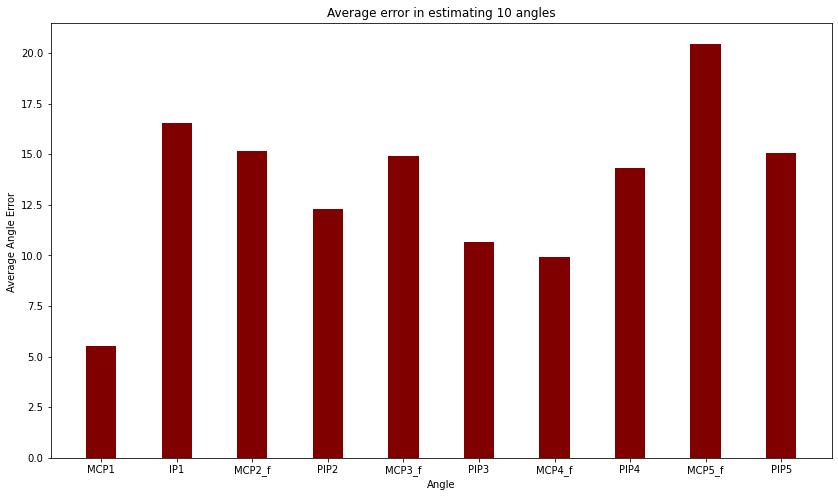

In [456]:
Error.to_csv('error_test1.csv')   

print(Error.mean())
fig = plt.figure(figsize=(14, 8))
 
# creating the bar plot
plt.bar(columns, Error.mean(), color ='maroon',width = 0.4)
 
plt.xlabel("Angle")
plt.ylabel("Average Angle Error ")
plt.title("Average error in estimating 10 angles")
plt.show()
